In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from scipy.interpolate import pchip
from scipy import interpolate
import glob


In [5]:
glob.glob('*.pickle')

[]

### Convert from dict to df
tracks = ['nom', 'pseudo', 'ideal', 'nom_RF75', 'nom_RF75_replaceFRAGHFWithTruth',
         'nom_RF75_replaceFRAGWithTruth', 'nom_RF75_replaceHFWithTruth',
         'nom_RF75_replaceWithTruth', 'nom_replaceFRAGHFWithTruth',
         'nom_replaceFRAGWithTruth', 'nom_replaceWithTruth', 'nom_replaceHFWithTruth']
sample='427080_Zprime'
in_dir = 'dicts'
out_dir = 'dataFrames'
if not (os.path.isdir(out_dir)): os.makedirs(out_dir)


for track in tracks:
    filename = f'{in_dir}/{sample}_{track}_jetVars.pickle'
    with open(filename, 'rb') as handle:
        jetDict = pickle.load(handle)
    df = pd.DataFrame.from_dict(jetDict)
    df['jet_jf_m'] = df['jet_jf_m']/1000
    
    out_filename = f'{out_dir}/{sample}_{track}.pickle'
    with open(out_filename, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open(f'{out_dir}/427080_Zprime_nom.pickle', 'rb') as handle:
    df = pickle.load(handle)

df.query('jet_jf_llr != -99').sort_values('jet_jf_dR', ascending=False)

,jet_jf_dR,jet_jf_efc,jet_jf_llr,jet_jf_nvtx,jet_jf_ntrkAtVx,jet_jf_nvtx1t,jet_jf_sig3d,l,c,b,jet_LabDr_HadF,jet_pt,jet_jf_m,jet_jf_n2t
596904,1.399468,0.015293,-3.769496,0.0,0.0,1.0,3.115427,1952510,426028,379314,0,107.542680,1.106674,1.0
14780,0.598744,0.110255,-4.553534,0.0,0.0,1.0,1.012152,1952510,426028,379314,0,110.156203,4.498881,0.0
852653,0.420834,0.029206,-3.642649,0.0,0.0,1.0,1.952403,1952510,426028,379314,0,684.629875,8.393509,2.0
1063965,0.341361,0.007620,-6.187280,0.0,0.0,1.0,0.121703,1952510,426028,379314,0,159.849000,0.522839,0.0
575356,0.314368,0.017612,-2.795506,1.0,2.0,0.0,12.147840,1952510,426028,379314,0,944.005437,3.305184,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248456,0.000041,0.532831,-3.301522,0.0,0.0,1.0,0.140752,1952510,426028,379314,4,547.169875,1.000517,0.0
237340,0.000039,0.918558,0.518622,1.0,2.0,2.0,21.640358,1952510,426028,379314,4,1079.896500,0.401960,0.0
447899,0.000038,0.732336,4.876380,3.0,9.0,0.0,26.812994,1952510,426028,379314,5,341.207531,6.768876,14.0
286847,0.000024,0.733811,-2.777714,0.0,0.0,1.0,0.139480,1952510,426028,379314,5,384.906656,0.486613,2.0


In [11]:
df['jet_LabDr_HadF'].value_counts()

0     536450
4     306645
5     292615
15        21
Name: jet_LabDr_HadF, dtype: int64

In [17]:
class JFPlots:
    def __init__(self, tracks, var, var_list, ylabel='Arbitrary units', sample='427080_Zprime',
                 in_dir='dataFrames', out_dir='JFPlots', nbins=1400, hist_range=(-10, 8), text=None):
        self.tracks = tracks
        self.baseline_track = tracks[0] # First track collection is list is always the baseline
        self.sample = sample
        self.in_dir = in_dir
        self.out_dir = out_dir
        if not (os.path.isdir(self.out_dir)): os.makedirs(self.out_dir)
        
        self.var = var
        self.xmin, self.xmax, self.xbins, self.var_label = var_list
        self.ylabel = ylabel
        self.text = text
        
        self.track_styles = {
            'nom': ["#000000", "Nominal"],
            'nom_RF75': ["#1f77b4", "FR"],
            'nom_replaceWithTruth': ["#7373c6", "PR"],
            'nom_RF75_replaceWithTruth': ["#f25396", "FR + PR"],  
            'pseudo': ["#ff7f0e", "Pseudo"],
            'ideal': ["#2ca02c", "Ideal"],
            
            # Apply pseudo tracks (separately to HF, FRAG, both)
            'nom_replaceHFWithTruth': ["#de425b", "HF only"],
            'nom_replaceFRAGWithTruth': ["#f18255", "FRAG only"],
            'nom_replaceFRAGHFWithTruth': ["#488f31", "HF + FRAG"],
            
            # Apply pseudo tracks to removed fakes (separately to HF, FRAG, both)
            'nom_RF75_replaceHFWithTruth': ["#de425b", "HF only"],
            'nom_RF75_replaceFRAGWithTruth': ["#f18255", "FRAG only"],
            'nom_RF75_replaceFRAGHFWithTruth': ["#488f31", "HF + FRAG"], 
        }
        
        # For ROC curves
        self.nbins = nbins
        self.hist_range = hist_range
        if '-rej' in self.var:
            self.jet = self.var.split('-')[0]
        
        
    def configure_plots(self, width=600, height=400, label_size=12, my_dpi=100,
                       roc_plots=False, jet_text=None):
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['xtick.labelsize'] = label_size 
        plt.rcParams['ytick.labelsize'] = label_size 
        plt.rcParams['axes.labelsize'] = label_size 
        fig = plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
        
        gs = gridspec.GridSpec(2,1 , height_ratios=[4,1])
        ax1 = plt.subplot(gs[0])
        ax2 = plt.subplot(gs[1])
        fig.subplots_adjust(hspace=0.07)
        fig.align_ylabels()
        
        # Settings for x and y axes
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax1.set_ylabel(self.ylabel, horizontalalignment='right', y=1.0)
        ax1.set_xlim([self.xmin, self.xmax])
        if roc_plots:
            ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
            ax1.set_yscale('log')
        
        ax2.set_ylabel("Ratio", horizontalalignment='right', y=1.0)
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.set_xlabel(self.var_label, horizontalalignment='right', x=1.0)
        ax2.set_xlim([self.xmin, self.xmax])
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        
        if roc_plots:
            ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
            if self.text is not None:
                ax1.text(0.01, 0.01, self.text, transform=ax1.transAxes)
        else:
            ax2.xaxis.set_major_locator(ticker.AutoLocator())
            #ax2.set_xticks(range(self.xmin, self.xmax))
            if jet_text is not None:
                ax1.text(0.01, 0.93, jet_text, transform=ax1.transAxes)
                
        
        if '_n' in self.var:
            ax2.set_xticks(np.arange(self.xmin+0.5, self.xmax+0.5,1), minor=True)
            ax2.set_xticklabels(np.arange(self.xmin, self.xmax), minor=True)
            ax2.set_xticklabels([])
            ax2.set_xticks([])
        
        return ax1, ax2
    
    
    def get_ratio(self, hist1, hist2):
        hist = []
        for i in range(len(hist1)):
            if hist2[i] == 0:
                if hist1[i] == 0: value = 1
                else: value = 0
            else: value = hist1[i]/hist2[i]
            hist.append(value)

        return hist
        
    
    def plot_vars(self, jet_text=None, jet=None):
        filename = self.var
        ax1, ax2 = self.configure_plots(jet_text=jet_text)
        ymaxs = []
    
        for track in self.tracks:
            filename += '_' + track
            with open(f'{self.in_dir}/427080_Zprime_{track}.pickle', 'rb') as handle:
                df = pickle.load(handle)
            
            query = 'jet_jf_llr != -99'
            if jet_text is not None:
                query += f' & jet_LabDr_HadF == {jet}'
                filename += '_' + str(jet)
                
            if track == self.baseline_track:
                baseline = df.query(query)[self.var]
            
            values = df.query(query)[self.var]
            
            y, x, _ = ax1.hist(values, bins=self.xbins,
                               range=(self.xmin, self.xmax), density=True, color=self.track_styles[track][0],
                               histtype='step', label=self.track_styles[track][1])
            ymaxs.append(y.max())
            #print(y.max())
            
            # Get ratio
            hist_base, bin_edges = np.histogram(baseline, bins=self.xbins, range=(self.xmin, self.xmax), density=True)
            hist, bin_edges = np.histogram(values, bins=self.xbins, range=(self.xmin, self.xmax), density=True)
            ratio = self.get_ratio(hist, hist_base)
            
            # Plot ratios
            left,right = bin_edges[:-1],bin_edges[1:]
            X = np.array([left,right]).T.flatten()
            Y = np.array([ratio,ratio]).T.flatten()
            ax2.plot(X,Y, color=self.track_styles[track][0], linewidth=1)
        
        ax1.set_ylim([0, max(ymaxs)*1.35])
        handles, labels = ax1.get_legend_handles_labels()
        new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles] # Draw lines for legend
        ax1.legend(loc='best', labelspacing=0.3, handles=new_handles, labels=labels, facecolor='none', edgecolor='none')
        
        plt.savefig(f'{self.out_dir}/{filename}.pdf', bbox_inches='tight', pad_inches=0.04)
    
    
    def plot_vars_jet(self):
        jets = {
            'b': [r'$b$-jets', 5],
            'c': [r'$c$-jets', 4],
            'l': ['Light-jets', 0]
        }
        
        for value in jets.values():
            self.plot_vars(jet_text=value[0], jet=value[1])
    
    
    def integrate_hist(self, hist_freqs, int_start):
        dx = self.hist_range[1] - self.hist_range[0]

        # Get index from xMin to min and max of interval using proportion of interval to domain
        i_min = int(round(self.nbins*(int_start - self.hist_range[0])/dx)) 
        i_max = int(round(self.nbins*(self.hist_range[1] - self.hist_range[0])/dx)) 

        return hist_freqs[i_min:i_max].sum()
    
    
    def inverse_func(self, y, function, sign=-1):
        # sign = -1 for decreasing fn and +1 for increasing fn
        epsilon = 1e-7
        x_max = self.hist_range[1]
        x_min = self.hist_range[0] # Start testing with x value in middle
        dx = x_max - x_min
        y_diff = 1
        
        while abs(y_diff) > epsilon and abs(dx) > epsilon:
            x0 = 0.5*(x_max + x_min)

            y_test = function(x0)
            y_diff = y - y_test
            # If y is greater than y_test for increasing fn
            # then increase x_min to x0 to decrease guessing gap
            # If y is greater than y_test for decreasing fn
            # then this would be negative
            # x_min to x0 to decrease guessing gap

            if y_diff*sign > 0: # If y is greater than y_test
                x_min = x0 # Increase x_min to 
            if y_diff*sign <= 0:
                x_max = x0

            dx = x_max - x_min

        return x0

    
    def get_roc_values(self):
        roc_values = {}
        filename = 'roc_values'
        
        for track in self.tracks:
            with open(f'{self.in_dir}/427080_Zprime_{track}.pickle', 'rb') as handle:
                df = pickle.load(handle)
            filename += '_' + track
            
            jets = {"b": 5, "c": 4, "l": 0}
            tot = {}
            llr = {}
            freqs = {}
            
            for jet in jets.keys():
                tot[jet] = df[jet][0]
                llr[jet] = df.query('jet_LabDr_HadF ==' + str(jets[jet]) + ' & jet_jf_llr !=-99')['jet_jf_llr'].tolist()
                freqs[jet], _ , _ = plt.hist(llr[jet], range=self.hist_range, bins=self.nbins)
            
            #print (len(llr['b'])/tot['b'])
            b_effs = np.linspace(0.1, 1, self.nbins)
            l_values = []
            c_values = []
            for eff in b_effs:
                if eff < len(llr['b'])/tot['b']: # less than max b eff
                    # solve for t
                    cut = self.inverse_func(eff, lambda x: self.integrate_hist(freqs['b']/tot['b'], x))
                    l_eff = self.integrate_hist(freqs['l'], cut)/tot['l']
                    c_eff = self.integrate_hist(freqs['c'], cut)/tot['c']
                    
                    if l_eff == 0: l_eff = 10e-7
                    if c_eff == 0: c_eff = 10e-7
                        
                    l_values.append(1/l_eff)
                    c_values.append(1/c_eff)

            roc_values[track + '_b'] = b_effs[:len(l_values)]
            roc_values[track + '_c'] = c_values
            roc_values[track + '_l'] = l_values
        
        with open(f'{filename}.pickle', 'wb') as handle:
            pickle.dump(roc_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return roc_values
                
    
    def plot_rocs(self):
        # See if roc values are already calculated, if not calculate them
        roc_file = 'roc_values'
        for track in self.tracks:
            roc_file += '_' + track
        try:
            with open(f'{roc_file}.pickle', 'rb') as handle:
                roc_values = pickle.load(handle)
        except:
            roc_values = self.get_roc_values()

        filename = self.var
        ax1, ax2 = self.configure_plots(roc_plots=True)
        
        for track in self.tracks:
            filename += '_' + track
            b_effs = roc_values[track + '_b']
            rejs = roc_values[track + '_' + self.jet]
            ax1.plot(b_effs, rejs, color=self.track_styles[track][0], label=self.track_styles[track][1])
            f = pchip(b_effs, rejs)
            
            # Ratio
            if track == self.baseline_track:
                f0 = f
                ratio = np.ones(len(b_effs))
                ratio_ix = 1
            else:
                ratio = f(b_effs) / f0(b_effs)  
                ratio_ix = f(rejs) / f0(rejs)
            ax2.plot(b_effs, ratio, color=self.track_styles[track][0], linewidth=1)
        
        ax1.legend(loc='best', labelspacing=0.3, facecolor='none', edgecolor='none')
        plt.savefig(f'{self.out_dir}/{filename}.pdf', bbox_inches='tight', pad_inches=0.04)
                
        

/Users/avalee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/avalee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/avalee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this 

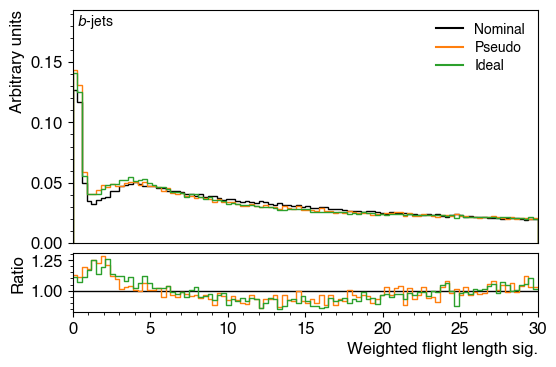

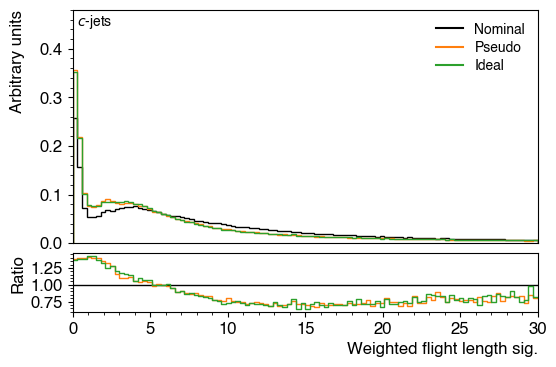

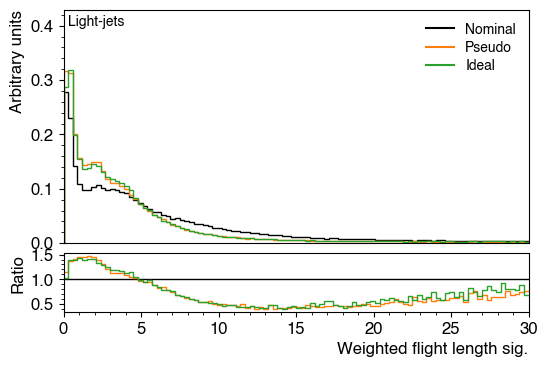

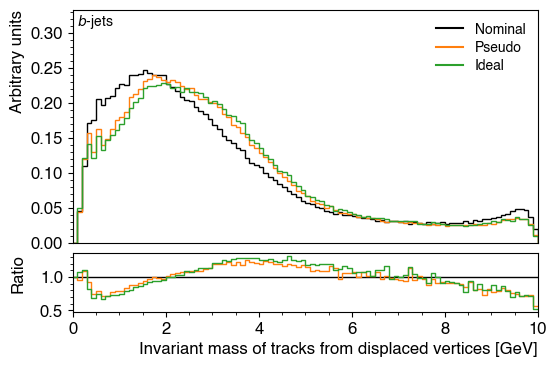

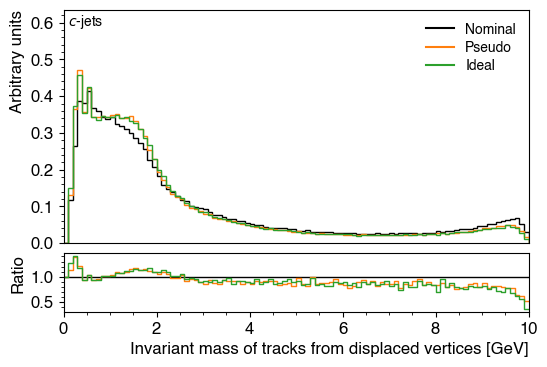

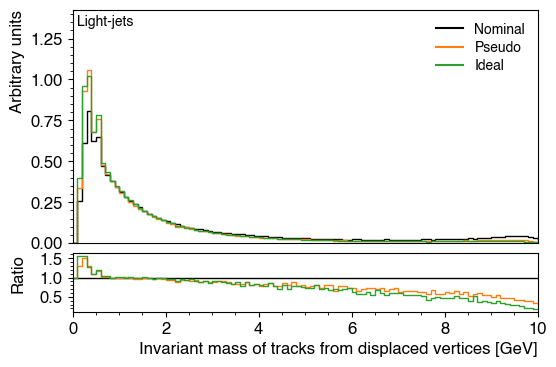

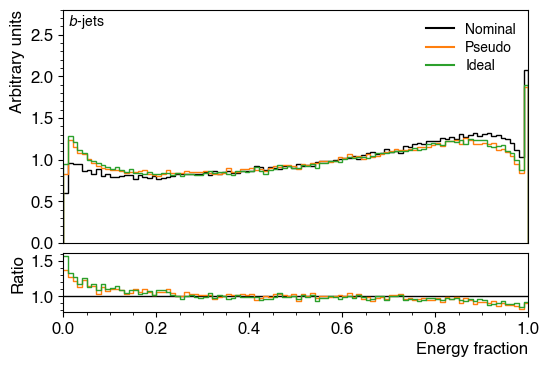

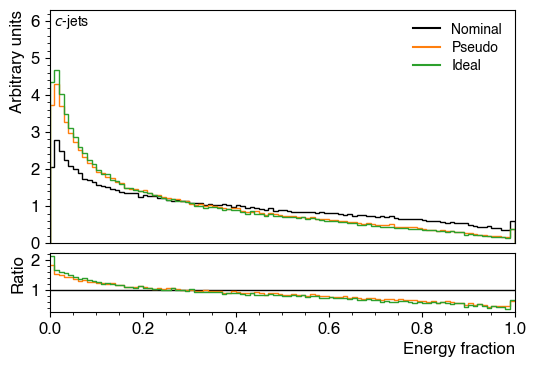

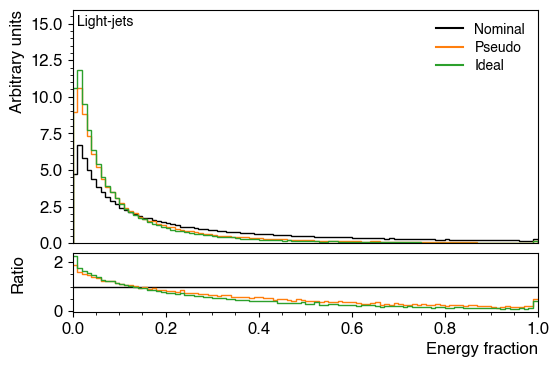

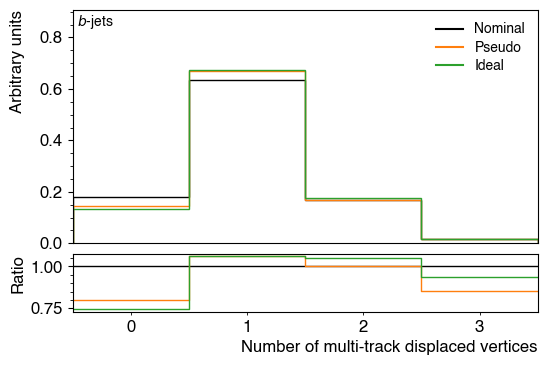

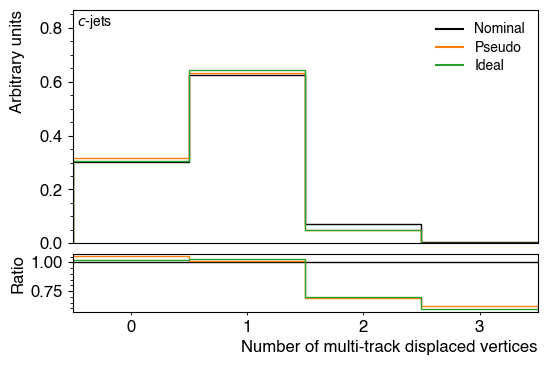

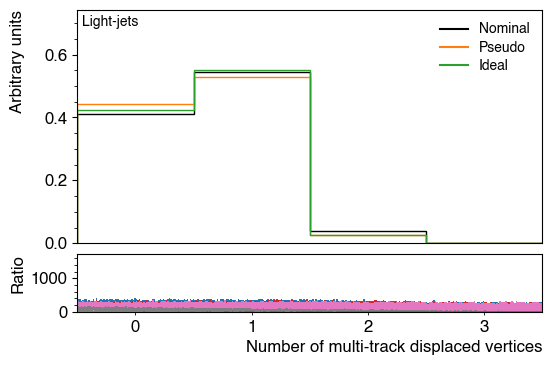

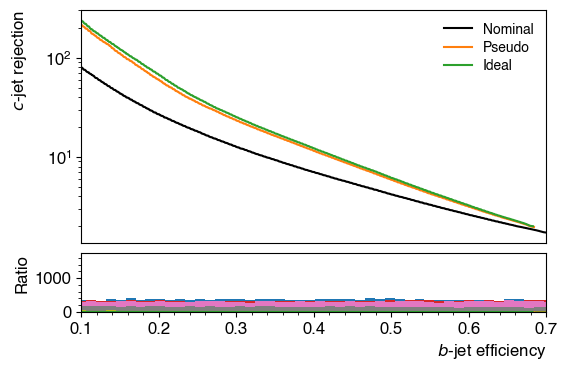

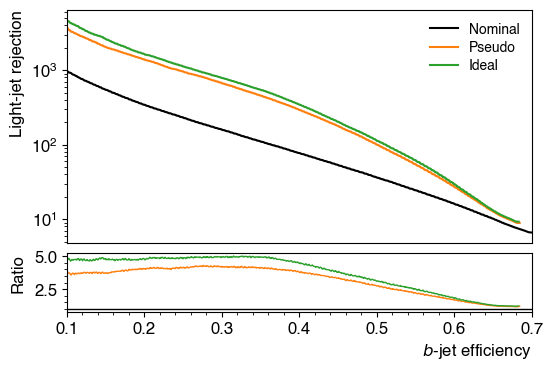

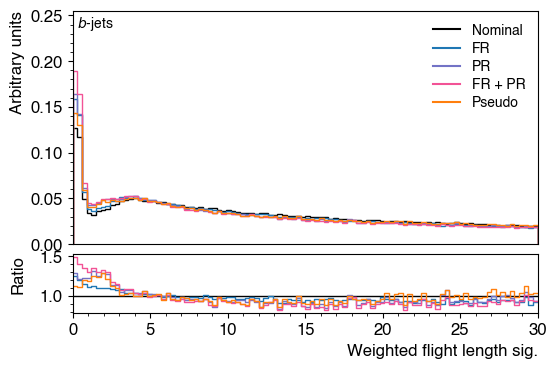

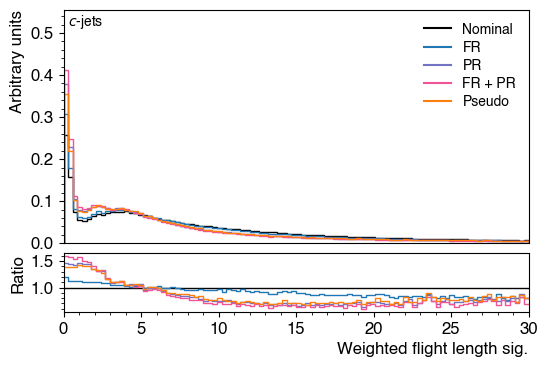

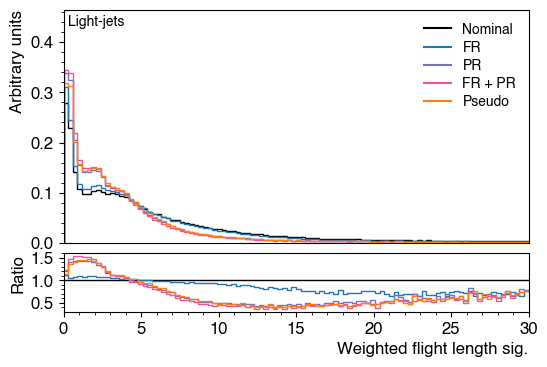

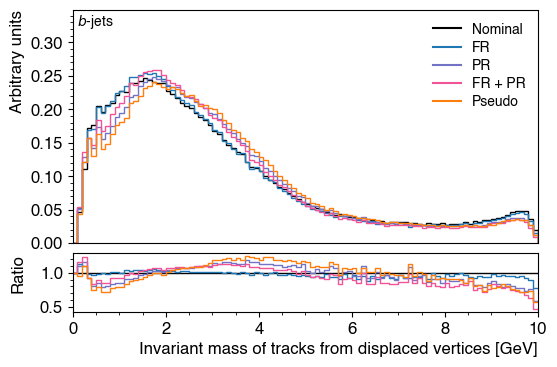

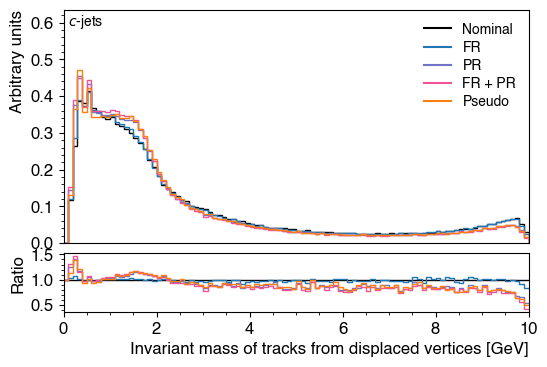

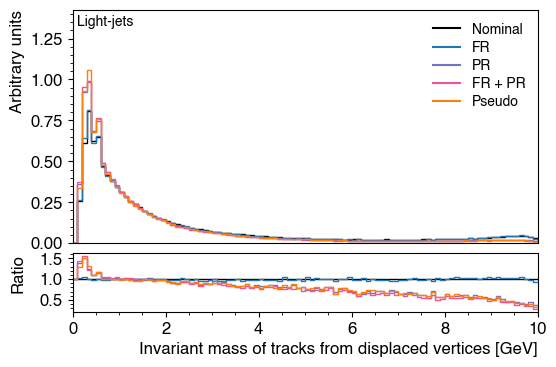

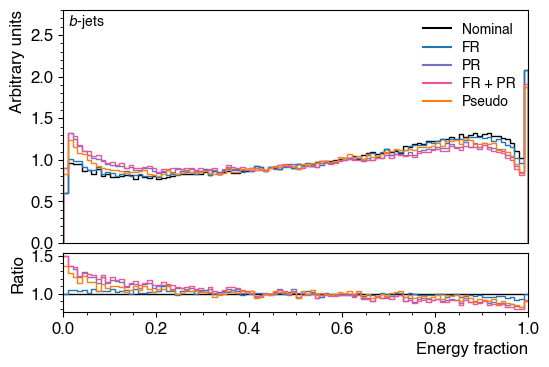

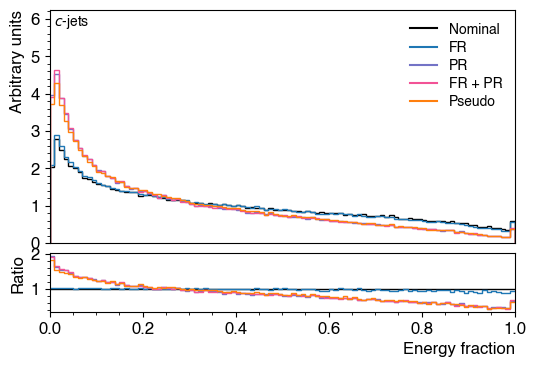

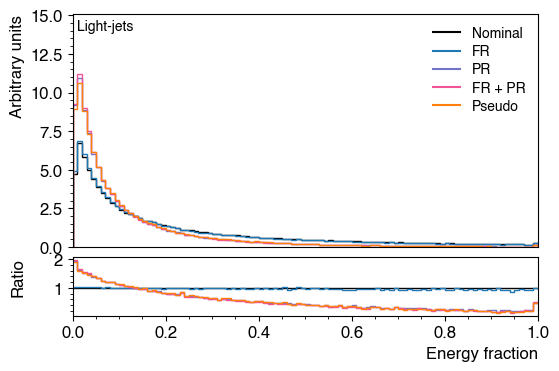

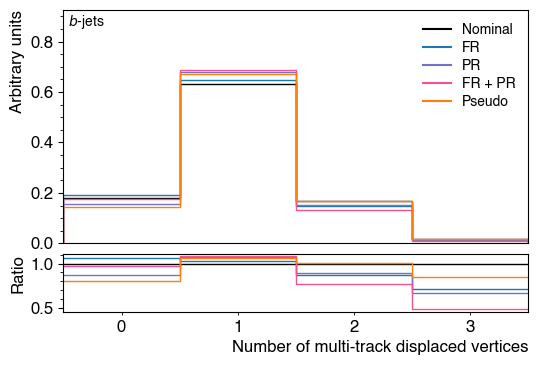

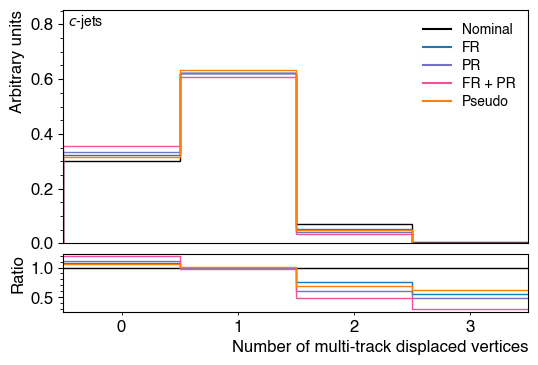

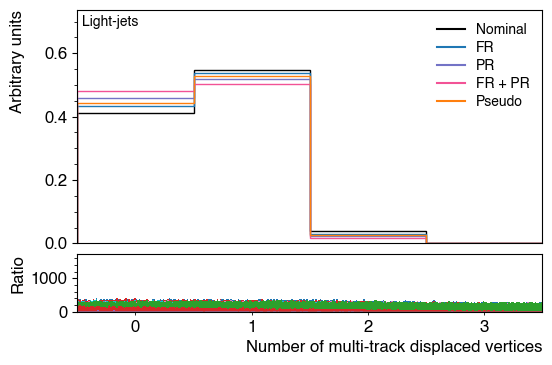

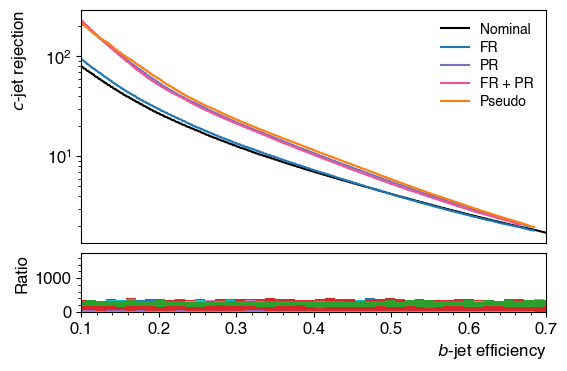

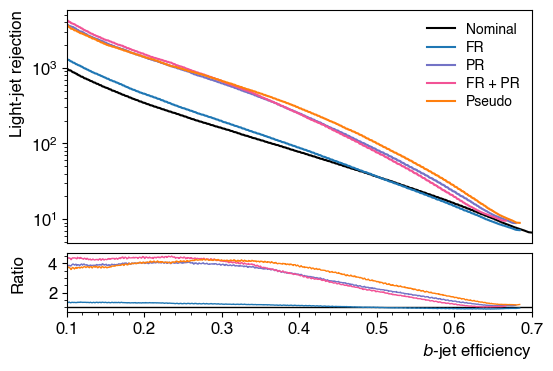

In [7]:
track_lists = [
    ['nom', 'pseudo', 'ideal'],
    ['nom', 'nom_RF75', 'nom_replaceWithTruth', 'nom_RF75_replaceWithTruth', 'pseudo'],
]

jet_vars = {
            'jet_jf_sig3d': [0, 30, 100, "Weighted flight length sig."],
            'jet_jf_m': [0, 10, 100, 'Invariant mass of tracks from displaced vertices [GeV]'],
            'jet_jf_efc': [0, 1, 100, 'Energy fraction'],
            'jet_jf_nvtx': [0, 4, 4, "Number of multi-track displaced vertices"],
        }

roc_vars = {
    'c-rej': [0.1, 0.7, None, r'$b$-jet efficiency'],
    'l-rej': [0.1, 0.7, None, r'$b$-jet efficiency'],
}

for tracks in track_lists:
    for var in jet_vars.items():
        JFPlots(tracks, var[0], var[1]).plot_vars_jet()
        
    JFPlots(tracks, 'c-rej', roc_vars['c-rej'], r'$c$-jet rejection').plot_rocs()
    JFPlots(tracks, 'l-rej', roc_vars['l-rej'], 'Light-jet rejection').plot_rocs()
    

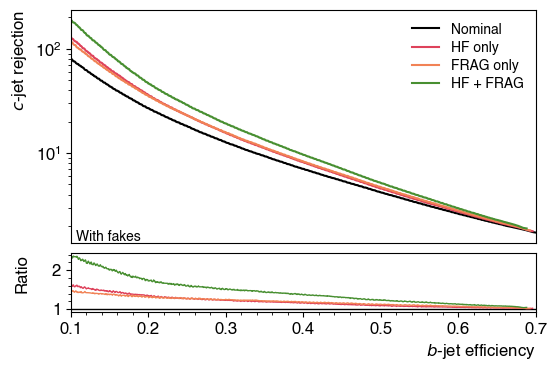

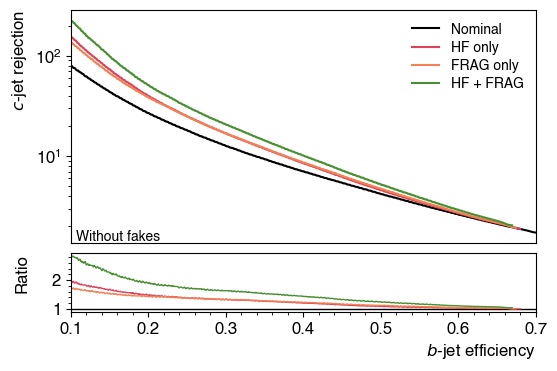

In [18]:
track_lists = [
    [['nom', 'nom_replaceHFWithTruth', 'nom_replaceFRAGWithTruth', 'nom_replaceFRAGHFWithTruth'], "With fakes"],
    [['nom', 'nom_RF75_replaceHFWithTruth', 'nom_RF75_replaceFRAGWithTruth', 'nom_RF75_replaceFRAGHFWithTruth'], "Without fakes"] 
]

roc_vars = {
    'c-rej': [0.1, 0.7, None, r'$b$-jet efficiency'],
    'l-rej': [0.1, 0.7, None, r'$b$-jet efficiency'],
}

for tracks in track_lists:
    JFPlots(tracks[0], 'c-rej', roc_vars['c-rej'], r'$c$-jet rejection', text=tracks[1]).plot_rocs()
    JFPlots(tracks[0], 'l-rej', roc_vars['l-rej'], 'Light-jet rejection', text=tracks[1]).plot_rocs()
    